# Анализ результатов А/В-тестирования

Задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Открытие данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from datetime import datetime, timedelta

In [2]:
try:
    ab_project_marketing_events = pd.read_csv('/Users/air/Downloads/ab_project_marketing_events.csv')
    final_ab_events = pd.read_csv('/Users/air/Downloads/final_ab_events.csv')
    final_ab_new_users = pd.read_csv('/Users/air/Downloads/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('/Users/air/Downloads/final_ab_participants.csv')
except:
    ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
    final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [3]:
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.


`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.


`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.


- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.


`final_ab_participants.csv` — таблица участников тестов.

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.


## Предобработка данных

In [7]:
def check_data(data):
    display(data.info())
    print('Количество пропущенных значений:')
    print(data.isna().sum())
    print()
    print('Количество дубликатов:', data.duplicated().sum())

### ab_project_marketing_events

In [8]:
check_data(ab_project_marketing_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

Количество пропущенных значений:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Количество дубликатов: 0


In [9]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])


**Вывод:** Пропусков и дубликатов а данных нет, данные приведены к нужному типу.

### final_ab_events

In [10]:
check_data(final_ab_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

Количество пропущенных значений:
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Количество дубликатов: 0


In [11]:
final_ab_events.event_dt = pd.to_datetime(final_ab_events['event_dt'])

### final_ab_new_users

In [12]:
check_data(final_ab_new_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

Количество пропущенных значений:
user_id       0
first_date    0
region        0
device        0
dtype: int64

Количество дубликатов: 0


In [13]:
final_ab_new_users.first_date = pd.to_datetime(final_ab_new_users['first_date'])

### final_ab_participants

In [14]:
check_data(final_ab_participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

Количество пропущенных значений:
user_id    0
group      0
ab_test    0
dtype: int64

Количество дубликатов: 0


### Вывод:

 - Дубликатов и пропусков в данных нет за исключением таблицы final_ab_events. Пропуски обнаружены в столбце details, это объясняется тем, что информация там указывается только для типа события - purchase.
 - Данные приведены к нужным форматам.

## Корректность проведения теста

### Временные рамки теста

#### Длительность теста

In [15]:
final_ab_events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

In [16]:
final_ab_events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

В ТЗ указано, что тестирование проходило с 7 декабря по 4 января, однако дата последнего события - 30 декабря.

#### Набор участников

In [17]:
final_ab_new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [18]:
final_ab_new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

В ТЗ указано, что набор участников шел с 7 декабря по 21 декабря, однако в данных есть участники, которые присоединились 23 декабря.

#### Пересечение с маркетинговыми мероприятиями

In [19]:
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Если учитывать, что участники тестирования приходят только из региона EU, то можно сказать, что время проведения теста пересекается с Christmas&New Year Promo(25.12 - 03.01). Это мероприятие застрагивает 5 дней тестирования. Стоит учитывать это при анализе результатов.

#### Вывод:

 - События тестирования представлены с 7 по 30 декабря.
 - Набор участников проходил с 7 по 23 декабря.
 - Время проведения теста частично пересекается с мероприятием Christmas&New Year Promo. Оно застрагивает 5 дней эксперимента.

### Аудитория теста

In [20]:
# Найдем пользователей, которые участвуют в нашем тесте(recommender_system_test)
ab_test_users = (
    final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']
)
# Найдем id этих пользователей
ab_test_id = ab_test_users.user_id.unique()

# Найдем их среди новых пользователей
new_users_ab = final_ab_new_users.query('user_id in @ab_test_id')


In [21]:
# Функция для вывода информации о пользователях на экран
def check_users(final_users, ab_test_users):
    
    print(
        'Количество участников A/B-теста:',
        final_users.user_id.nunique()
    )
    
    print(
        'Процент новых пользователей, участвующих в A/B-тесте: {:.2%}'
        .format(final_users['user_id'].nunique() / final_ab_new_users['user_id'].nunique())
    )
    
    print(
        'Регионы пользователей, участвующих в A/B-тесте:',
        final_users['region'].unique()
    )
    
    print(
        'Процент пользователей из региона EU среди учестников теста: {:.2%}'
        .format(final_users[final_users['region'] == 'EU']['user_id'].nunique() / final_users.user_id.nunique())
    )
    
    print(
        'Количество участников в группе А:',
        ab_test_users[ab_test_users['group'] == 'A'].user_id.nunique()
    )
    
    print(
        'Количество участников в группе B:',
        ab_test_users[ab_test_users['group'] == 'B'].user_id.nunique()
    )
    print('---')
    print()
    print(
        'Процент участников теста от количества новых пользователей из региона EU: {:.2%}'
        .format(ab_test_users.user_id.nunique() / final_ab_new_users[final_ab_new_users['region'] == 'EU'].user_id.nunique())       
    )
    
    
    
    

In [22]:
check_users(new_users_ab, ab_test_users)

Количество участников A/B-теста: 6701
Процент новых пользователей, участвующих в A/B-тесте: 10.85%
Регионы пользователей, участвующих в A/B-тесте: ['EU' 'APAC' 'CIS' 'N.America']
Процент пользователей из региона EU среди учестников теста: 94.78%
Количество участников в группе А: 3824
Количество участников в группе B: 2877
---

Процент участников теста от количества новых пользователей из региона EU: 14.48%


**Итог:**
 - В тесте 6701 участник, это немного больше, чем ожидаемое количество участников(6000).
 - Аудитория теста –– примерно 11% новых пользователей(ожидаемое - 15%).
 - Есть участники из регионов: 'EU' 'APAC' 'CIS' 'N.America', ожидались участники только из EU.
 - Пользователи из региона EU составляют примерно 95%.
 - Распределение по группам неравномерное: в группе В практически на тысячу участников больше.

#### Пересечения с конкурирующим тестом

In [24]:
# Посмотрим, есть ли пользователи, которые участвуют в двух группах одновременно
report = (
    final_ab_participants.groupby('user_id')
    .agg({'ab_test':'count'})
    .sort_values(by='ab_test', ascending=False)
    .reset_index()
)

report.head()

,user_id,ab_test
0,BD23AF6242CA944B,2
1,395461648C47B5E1,2
2,72073BB7348162AE,2
3,CC705D51C74418AD,2
4,19AC976D25997BE9,2


In [25]:
# Посчитаем, сколько пользователей попали в два теста одновременно
report[report['ab_test'] == 2].user_id.nunique()


1602

In [26]:
report[report['ab_test'] == 2].user_id.nunique() / new_users_ab.user_id.nunique()

0.23906879570213402

In [27]:
# Сохраним id пользователей, которые участвуют в двух группах одновременно
report_id = report[report['ab_test'] == 2].user_id.unique()

У нас получилось 1602 участника A/B-теста, которые участвуют сразу в двух тестированиях. Это составляет примерно 24% от общего числа участников. 



#### Пересечения по группам

In [28]:
# Посмотрим, есть ли пользователи из нашего теста, которые попали одновременно в две группы
(
    ab_test_users
    .groupby('user_id')
    .agg({'group' : 'count'})
    .reset_index()
    .group.unique()
)

array([1])

Среди участников нашего теста нет пользователей, которые попали одновременно в две группы. Как мне кажется, стоит убрать пользователей, которые участвуют сразу в двух тестах, так как это может помешать анализу результатов тестирования.

In [29]:
# Удалим пользователей, которые участвуют сразу в двух тестах
ab_test_users = ab_test_users.query('user_id not in @report_id')


# Создадим табличку с общей информацией о пользователях
ab_users = ab_test_users.merge(new_users_ab, on='user_id').drop(columns = 'ab_test')

# Оставим только пользователей, которые из европейского региона. 
ab_users = ab_users[ab_users['region'] == 'EU']

#### Конечная информация об участниках теста

In [30]:
check_users(ab_users, ab_users)

Количество участников A/B-теста: 4749
Процент новых пользователей, участвующих в A/B-тесте: 7.69%
Регионы пользователей, участвующих в A/B-тесте: ['EU']
Процент пользователей из региона EU среди учестников теста: 100.00%
Количество участников в группе А: 2713
Количество участников в группе B: 2036
---

Процент участников теста от количества новых пользователей из региона EU: 10.26%


#### Период анализа действий пользователей

В ТЗ указано, что мы рассматриваем метрики по истечении срока 14 дней. Таким образом, для каждого пользователя оставим только те события, которые входят в 14-дневное окно.

In [31]:
# Оставим среди событий теста только те, которые совершили пользователи нашего теста
ab_users_id = ab_users.user_id.unique()
ab_events = final_ab_events.query('user_id in @ab_users_id')

# Добавим в таблицу о событиях информацию о пользователях
ab_events = ab_events.merge(ab_users, on = 'user_id')

In [32]:
# Найдем последнюю возможную дату события(дата первого использования + 14 дней)
ab_events['last_suitable_acquisition_date'] = ab_events['first_date'] + timedelta(days = 14)

# Оставим информацию только о тех событиях, которые совершились до этой даты включительно
ab_events = ab_events.query('last_suitable_acquisition_date >= event_dt')


In [33]:

# Удалим вспомогательный столбец
ab_events = ab_events.drop(columns='last_suitable_acquisition_date')

### Вывод:

- Были удалены данные об участниках, которые участвовали одновременно в двух тестах, так как это могло помешать анализу тестирования. Также были удалены данные об участниках из других регионов.
- В конечном итоге в тесте участвовали 4749 пользователя(ожидаемое количество - 6000).
- Аудитория составляет примерно 7.7% новых пользователей из региона 'EU'(ожидалось 15% из региона EU).
- Пользователи неравномерно разделены по группам, количество участников в группе А составляет 2713, в группе В - 2036.
- Время проведения теста частично пересекается с маркетинговым мероприятием, оно затрагивает 5 дней от эксперимента.

## Исследовательский анализ данных

In [34]:
ab_events

,user_id,event_dt,event_name,details,group,first_date,region,device
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,2020-12-07,EU,Android
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,2020-12-07,EU,Android
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,2020-12-07,EU,Android
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,A,2020-12-07,EU,Android
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,A,2020-12-07,EU,Android
...,...,...,...,...,...,...,...,...
17521,64597B30278462F5,2020-12-23 14:14:46,login,NaN,A,2020-12-21,EU,Android
17522,1484BBF124DB1B18,2020-12-21 17:51:44,login,NaN,A,2020-12-21,EU,PC
17523,1484BBF124DB1B18,2020-12-22 16:02:18,login,NaN,A,2020-12-21,EU,PC
17524,1484BBF124DB1B18,2020-12-27 10:53:34,login,NaN,A,2020-12-21,EU,PC


In [35]:
ab_events.user_id.nunique()

2594

Как мы видим, из 4749 участников теста только 2594 совершали какие-либо действия, что довольно странно.

### Распределение событий по группам

In [36]:
ab_events.groupby('group').agg({'event_name':'count', 'user_id':'nunique'})

,event_name,user_id
group,,
A,13374,1939
B,3544,655


**Вывод:** 
 - События в группах распределяются неравномерно. Пользователями из группы А совершены 13742 действий(практически 80% всех событий), а пользователями из группы В только 3784.
 - В группе А 1939 активных пользователей, в то время как в группе В лишь 655. 

### Распределение событий на пользователя

In [37]:
def count_events(data):
    
    # Сгруппируем данные по имени пользователя и найдем количество событий
    report = data.groupby('user_id').agg({'event_name':'count'})
    
    plt.figure(figsize=(15,3))
    sns.boxplot(x = report['event_name'], color = 'pink')
    plt.title('Распределение событий на пользователя')
    plt.xlabel('Количество событий')
    
    
    print('Среднее количество событий на пользователя: {:.2f}'.format(report['event_name'].mean()))
    print('Медианное количество событий на пользователя: {:.2f}'.format(report['event_name'].median()))

Все пользователи:

Среднее количество событий на пользователя: 6.52
Медианное количество событий на пользователя: 6.00


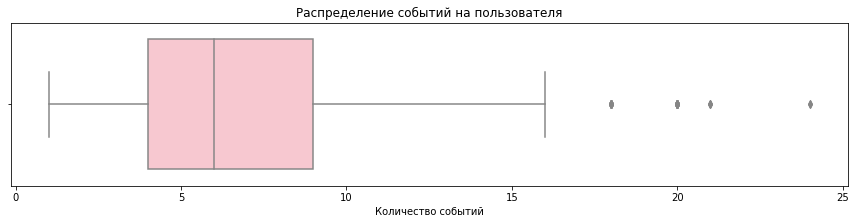

In [38]:
print('Все пользователи:')
print('')
count_events(ab_events)

На диаграмме размаха видно, что есть пользователи, которые совершают 15+ действий. 

Группа А:

Среднее количество событий на пользователя: 6.90
Медианное количество событий на пользователя: 6.00


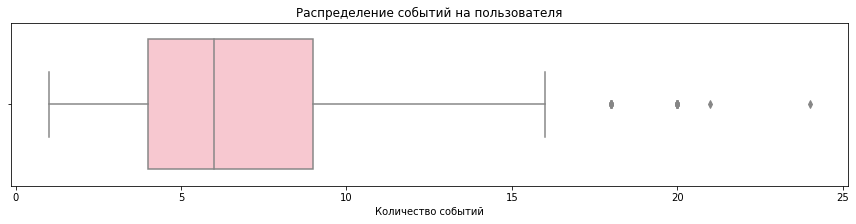

In [39]:
group_a = ab_events[ab_events['group'] == 'A']

print('Группа А:')
print('')
count_events(group_a)

Группа В:

Среднее количество событий на пользователя: 5.41
Медианное количество событий на пользователя: 4.00


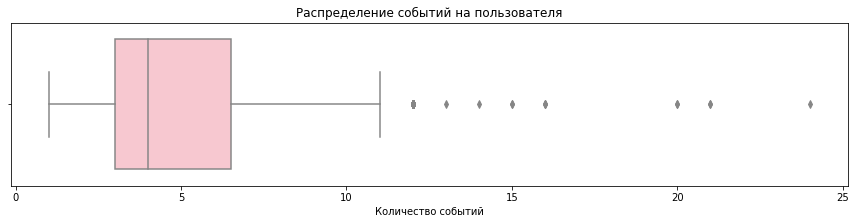

In [40]:
group_b = ab_events[ab_events['group'] == 'B']

print('Группа В:')
print('')
count_events(group_b)

**Вывод:**

 - Разброс пользователей по количеству событий от 0 до 15 событий. Есть выбросы: пользователи, которые совершают 15+ действий.
 - В среднем пользователи совершают около 6-7 действий. 
 - В группе А среднее количесво событий на пользователя –– 7, медианное –– 6.
 - В группе В среднее количество событий на пользователя –– 6, медианное –– 4.
 - Можно сделать вывод, что во второй группе пользователи в среднем совершают меньше действий, чем в первой.

### Распределение событий по дням

Как число событий в выборках распределено по дням?

In [41]:
# Добавим в таблицу дату события
ab_events['dt'] = ab_events['event_dt'].dt.date

# Обновим таблицы с группами
group_a = ab_events[ab_events['group'] == 'A']
group_b = ab_events[ab_events['group'] == 'B']

In [42]:
# Функция для построения графиков
def event_by_dt(data, i, title):
    
    report = data.groupby('dt').agg({'user_id':'count'}).reset_index()
    axs[i].bar(report['dt'], report['user_id'], color='pink')
    axs[i].tick_params(axis='x', rotation = 90)
    axs[i].set_title(title)
    axs[i].set_xlabel('Дата')
    axs[i].set_ylabel('Количество пользователей')
    

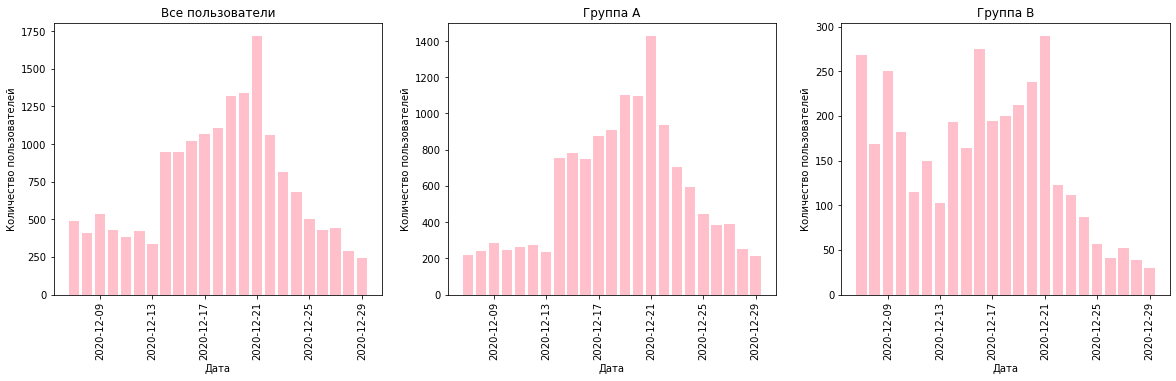

In [43]:
fig, axs = plt.subplots(1,3, figsize=(20,5))


event_by_dt(ab_events, 0, 'Все пользователи')
event_by_dt(group_a, 1, 'Группа А')
event_by_dt(group_b, 2, 'Группа В')

 - Как мы видим на графиках, наблюдается резкий всплеск событий в 21 декабря, я связываю это с приближающимся католическим рождеством, после чего активность снижается. 
 - Количество действий для группы А намного больше, чем в группе В, я связываю это с количеством активных пользователей в этой группе.
 - В группе В активность неоднородная: наблюдается несколько резких скачков; после 21, как и в другой группе, наблюдается спад. 

Рассмотрим среднее распределение событий на пользователя:

In [44]:
def mean_events_per_user(data, i, title):
    
    report = data.groupby('dt').agg({'event_name':'count', 'user_id':'nunique'}).reset_index()
    report['mean_events_per_user'] = report['event_name'] / report['user_id']
    
    axs[i].plot(report['dt'], report['mean_events_per_user'], color='c')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_title(title)
    axs[i].set_xlabel('Дата')
    axs[i].set_ylabel('Количество пользователей')

Text(0.5, 0.98, 'Среднее количество событий на пользователя в день')

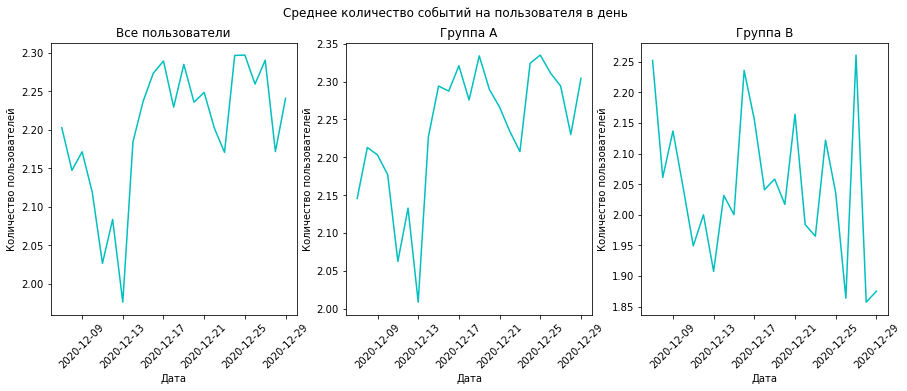

In [45]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

mean_events_per_user(ab_events,0, 'Все пользователи')
mean_events_per_user(group_a, 1, 'Группа А')
mean_events_per_user(group_b, 2, 'Группа В')
plt.suptitle('Среднее количество событий на пользователя в день')

### Число уникальных пользователей в день

In [46]:
def find_dau(data, i, title):
    
    report = data.groupby('dt').agg({'user_id':'nunique'})
    
    axs[i].plot(report, color='c')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_title(title)
    axs[i].set_xlabel('Дата')
    axs[i].set_ylabel('Количество пользователей')
    
    
    print('Среднее DAU('+ title+ ')', int(report.mean()))

Среднее DAU(Все пользователи) 331
Среднее DAU(Группа А) 257
Среднее DAU(Группа В) 74


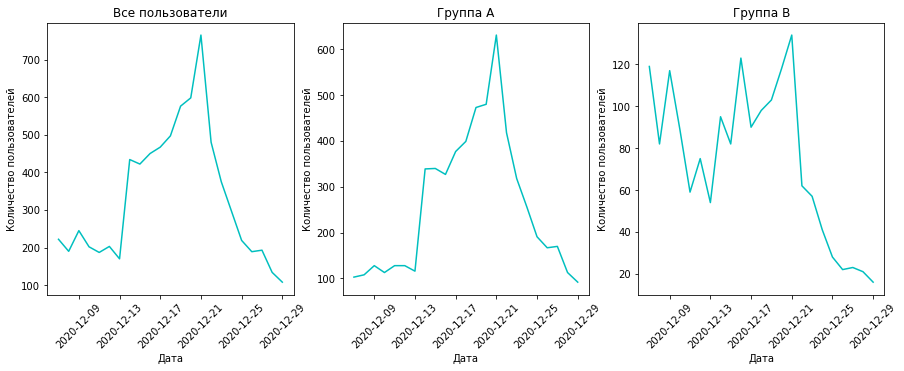

In [47]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

find_dau(ab_events, 0, 'Все пользователи')
find_dau(group_a, 1, 'Группа А')
find_dau(group_b, 2, 'Группа В')

**Вывод:**
 - Число уникальных пользователей распределяется соответственно числу действий(аналогичные скачки и спады).
 - В среднем в день наблюдается 329 уникальных пользователей. 
 - Для группы А –– это 264 пользователя, в группе В –– 76.

### Воронка событий

In [48]:
# Выделим в отдельные таблицы информации о пользователях из разных групп

group_a_users = ab_users[ab_users['group'] == 'A']
group_b_users = ab_users[ab_users['group'] == 'B']

In [49]:
# Функиця для построения воронки событий(на вход принимает датасет и количество уникальных пользователей)
def make_funnel(data, unique_count):
    
    
    # Создадим вороонку
    report = (
    data.groupby('event_name').agg({'user_id' : 'nunique'})
    .sort_values(by = 'user_id', ascending = False)
    .reset_index()
    )

    # Добавим столбец со значением конверии
    report['conversion'] = report['user_id'] / unique_count

    # Добавим столбцы, показывающие, сколько пользователей было на предыдущем шаге
    report['previous_step'] = report['user_id'].shift()

    # И конверсию в следующий шаг
    report['step_conversion'] = report['user_id'] / report['previous_step']
    
    return report

In [50]:
# Функция для визуализации воронки
def show_funnel(report):
    
    # Удалим дейсвтие 'product_cart' из воронки
    report = report.query('event_name != "product_cart"')
    
    sns.barplot(
        data = report,
        x = 'conversion',
        y = 'event_name',
        palette = 'pastel'
    )
    plt.title('Воронка событий')
    plt.xlabel('Процент пользователей')
    plt.ylabel('Название события')

#### Все пользователи

In [51]:
# Построим воронку событий по всем пользователям
report = make_funnel(ab_events, ab_users.user_id.nunique())
report

,event_name,user_id,conversion,previous_step,step_conversion
0,login,2593,0.546010,NaN,NaN
1,product_page,1632,0.343651,2593.0,0.629387
2,purchase,804,0.169299,1632.0,0.492647
3,product_cart,773,0.162771,804.0,0.961443


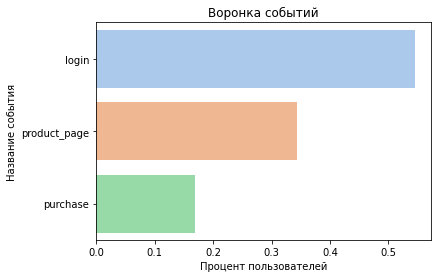

In [52]:
show_funnel(report)

- До первого шага воронки(авторизация в приложении) доходят приблизительно 55% пользователей. 
- Как мне кажется, шаг product_cart(скорее всего добавление товара в корзину) является необязательным, поэтому до него доходят даже меньше пользователей, чем до целевого действия - покупка. Этот шаг не участвует в воронке.

#### Группа А

In [53]:
report = make_funnel(group_a, group_a_users.user_id.nunique())
report

,event_name,user_id,conversion,previous_step,step_conversion
0,login,1939,0.714707,NaN,NaN
1,product_page,1265,0.466273,1939.0,0.652398
2,purchase,613,0.225949,1265.0,0.484585
3,product_cart,589,0.217103,613.0,0.960848


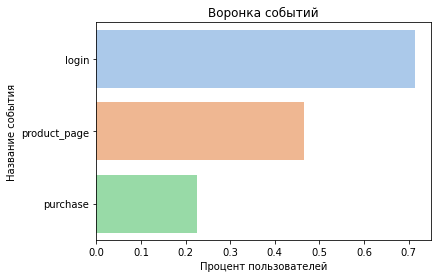

In [54]:
show_funnel(report)

- В первой группе примерно 70% пользователей доходят до первого шага, на страницу товара переходит примерно 47%, а доходят до покупки 23%. 

#### Группа В

In [55]:
report = make_funnel(group_b, group_b_users.user_id.nunique())
report

,event_name,user_id,conversion,previous_step,step_conversion
0,login,654,0.321218,NaN,NaN
1,product_page,367,0.180255,654.0,0.561162
2,purchase,191,0.093811,367.0,0.520436
3,product_cart,184,0.090373,191.0,0.963351


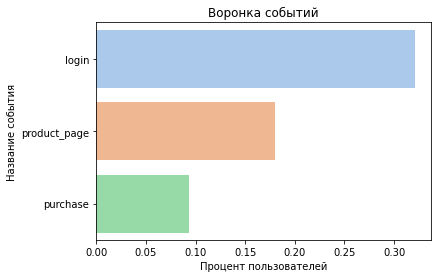

In [56]:
show_funnel(report)

- Во второй группе только 32% пользователей доходят до авторизации в приложении, это очень маленькая цифра. 
- До покупки доходит менее 10% пользователей.

#### Вывод:

 - Среди всех пользователей до 1 шага доходят только 55% пользователей. Конверсия в покупку составляет 17%.
 - В группе А до первого шага доходят около 70% пользователей. Конверсия в покупку составляет 23%.
 - В группе В около 32% доходят до первого шага, а конверсия в покупку менее 10%.

### Вывод:

 - В группах неравномерно распределены количество событий и количество активных пользователей. В группе А было совершено 13742 действия, в то время как в группе В лишь 3784.
 - В среднем в группе А –– 7 событий на пользователя, в группе В –– 6.
 - По дням в группе А, как и среди всех пользователей, наблюдается повышение активности с 14 декабря по 22 декабря, затем наблюдается спад. 
 - В группе В количество событий в день неравномерное, однако тоже наблюдается спад после 22 декабря. Стоит учитывать, что в среднем в день в группе В совершается событий примерно в 4 раза меньше, чем в группе А.
 - Среднее количество уникальных пользователей для группы А –– 264, для группы В –– 76.
 - Среди всех пользователей конверсия в покупку составляет 17%.
 - До первого шага в приложении в группе А доходят 70% пользователей, в группе В лишь 32%.
 - Конверсия в покупку в группе А составляет 23%, в группе В –– менее 10%.
 - Складывается ощущение, что во второй группе рекомендательная система дает сбой или есть какие-либо проблемы с переходом к авторизации, что приводит к тому, что пользователи не доходят даже до первого шага.
 - При анализе А/В тестирования стоит учитывать, что существует очень большая разница между количеством активных пользователей в 1 и 2 группах. 

## Изучение результатов тестирования

### Оценка статистической разницы между группами

In [57]:
# Посмотроим воронку для группы А
count_a = group_a_users.user_id.nunique()
report_a = make_funnel(group_a, count_a)

# Группы В
count_b = group_b_users.user_id.nunique()
report_b = make_funnel(group_b, count_b)


In [58]:
# Соединим две таблицы и оставим только значения пользователей в каждом из событий
report = report_a.merge(report_b[['event_name', 'user_id']], left_on='event_name', right_on='event_name',
          suffixes=('_a', '_b'))
report = report.drop(columns = ['conversion', 'previous_step', 'step_conversion', 'conversion'])

report

,event_name,user_id_a,user_id_b
0,login,1939,654
1,product_page,1265,367
2,purchase,613,191
3,product_cart,589,184


Проверим, находят ли статистические критерии разницу между группами А и В. Для этого я буду использовать z-тест для проверки гипотезы о равенстве долей.

In [59]:
# Функция для проверки равенства долей

def check_proportion(successes1, successes2, trials1, trials2):
    
    alpha = 0.05 # критический уровень статистической значимости
    
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2)
    )
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

In [60]:
id_a = np.array(report['user_id_a'])
id_b = np.array(report['user_id_b'])

In [61]:
for i in range(len(id_a)):
    successes1 = id_a[i]
    successes2 = id_b[i]
    
    check_proportion(successes1, successes2, count_a, count_b)

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод:** Получилось нечто странное, p-value во всех случаях равен 0. Между долями есть статистически значимая разница. 

## Вывод:

 - В ходе предобработки значимых пропусков и дубликатов в данных не обнаружено, данные были приведены к нужному типу.
 - В данных были участники, которые участвовали одновременно в двух тестах, информация о них была удалена.
 - Конечная аудитория теста не соответствует техническому заданию.
 - Время проведения теста частично пересекается с маркетинговым мероприятием, оно затрагивает 5 дней от эксперимента.
 - Количество событий и активных пользователей в группах распределено неравномерно. В группе В лишь 32% пользователей совершали действия. 
 - В среднем в группе А –– 7 событий на пользователя, в группе В –– 6.
 - В количестве событий наблюдается повышение активности с 14 декабря по 22 декабря, затем наблюдается спад.
 - Среди всех пользователей конверсия в покупку составляет 17%.
 - До первого шага в приложении в группе А доходят 70% пользователей, в группе В лишь 32%.
 - Конверсия в покупку в группе А составляет 23%, в группе В –– менее 10%.
 - Статистический тест показал, что в группах между долями есть статистически значимая разница, следовательно, тестирование следует считать некорректным.
 - Таким образом, тестирование прошло неуспешно. Группа В показала результаты намного хуже, чем группа А.
 - Как мне кажется, проблема заключается в том, что в группе В пользователи испытывали трудности с новой рекомендательной системой, из-за чего не проходили к следующим шагам в приложении.
 
 ---
 
 **Корректность теста:**
 - Как мне кажется, доверять результатам данного теста не рекомендуется: аудитория теста не совпадала с указанной в ТЗ, более 20% пользователей участвовали в двух тестированиях одновременно, временные рамки предоставленных данных не совпадали с указанными в ТЗ, были участники из других регионов, пересечение с маркетинговыми мероприятиями, а также проведение теста в декабре(сезонное повышение активности). Исходя из этих тезисов, можно сказать, что результаты теста могут существенно отличаться от реальных.